In [1]:
segmentation_checkpoint="axial_segmentation_effseg_163725-epoch-100.pth"
axial_det_checkpoint="axial_detection_effdet_134352-epoch-52.pth"

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

import pydicom
import pylibjpeg

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
from effdet import create_model

timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random
import numpy as np

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms.functional as TF
# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold


# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"

IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')

In [4]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
test_df

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


## read dcm file


In [5]:
def rescale_img_to_hu(dcm_ds):
    """Rescales the image to Hounsfield unit.
    """
    return dcm_ds.pixel_array * dcm_ds.RescaleSlope + dcm_ds.RescaleIntercept


def read_dcm(patient_dir, num_instance):
    dcm_path = os.path.join(patient_dir, f"{int(num_instance)}.dcm")
    ds = pydicom.dcmread(dcm_path)
    img2d = rescale_img_to_hu(ds)
    return normalize_hu(img2d)

def read_patient_dcm(patient_dir):
    """
    여기서 이미지를 정상적인 순서로 돌려 놓는다
    :param patient_dir:
    :return:
    """
    num_slices = len(glob.glob(patient_dir + "/*.dcm"))
    # print(f"total slices {num_slices}")
    imgs = np.zeros((num_slices, 512, 512))
    image_positions = np.zeros((num_slices, 3))
    image_orientations = np.zeros((num_slices, 6))
    pixel_spacings = np.zeros((num_slices, 2))
    slice_thicknesses = np.zeros((num_slices, 1))

    ignore_count = 1
    for i in range(num_slices):
        dcm_path = os.path.join(patient_dir, f"{i+ignore_count}.dcm")
        while os.path.exists(dcm_path) == False:
            ignore_count += 1
            dcm_path = os.path.join(patient_dir, f"{i+ignore_count}.dcm")
        ds = pydicom.dcmread(dcm_path)

        image_positions[i, :] = ds.ImagePositionPatient
        image_orientations[i, :] = ds.ImageOrientationPatient
        pixel_spacings[i, :] = ds.PixelSpacing
        slice_thicknesses[i, :] = ds.SliceThickness

        img2d = rescale_img_to_hu(ds)

        imgs[i] = img2d

    is_flip = False
    # check z is in good direction
    if image_positions[0, 2] < image_positions[1, 2]:
        is_flip = True
        # flip image in z direction
        imgs = np.flip(imgs, axis=0)
        image_positions = np.flip(image_positions, axis=0)
        pixel_spacings = np.flip(pixel_spacings, axis=0)
        slice_thicknesses = np.flip(slice_thicknesses, axis=0)

    aspect = calculate_aspect(image_positions, pixel_spacings)
        
    return imgs, aspect, pixel_spacings[0, 0]


def normalize_hu(data):
    # normalize to 0-1
    # return (data - data.min()) / data.max()
    data = np.clip(data, a_min=-2242, a_max=2242) / 4484 + 0.5
    return data

def calculate_aspect(image_positions, pixel_spacings):
    """
    calculate z aspect, z 를 몇배로 늘여야 하는가야
    :param image_positions:
    :param pixel_spacings:
    :return:
    """
    height = image_positions[0, 2] - image_positions[1, 2]
    pixel_spacing = pixel_spacings[0, 0]
    aspect = height / pixel_spacing
    return aspect

In [6]:
from efficientunet import *
def get_axial_segmentation_model(checkpoint):
    model = get_efficientunet_b5(out_channels=2, concat_input=True, pretrained=True)
    
    state = torch.load(os.path.join(DATA_DIR, 'checkpoint', checkpoint))
    model.load_state_dict(state["model"])
    model.eval()
    return model.to(device)
    
seg_model = get_axial_segmentation_model(segmentation_checkpoint)

In [7]:
from effdet import create_model

def get_axial_detection_model(checkpoint, image_size=512):
    model = create_model('efficientdetv2_ds' , bench_task='predict' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True, max_det_per_image=1)

    state = torch.load(os.path.join(DATA_DIR, 'checkpoint',checkpoint))
    model.load_state_dict(state["model"])
    model.eval()
    return model.to(device)

det_model = get_axial_detection_model(axial_det_checkpoint)

In [8]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).sort_values('StudyInstanceUID')
train_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
1837,1.2.826.0.1.3680043.10001,0,0,0,0,0,0,0,0
823,1.2.826.0.1.3680043.10005,0,0,0,0,0,0,0,0
1021,1.2.826.0.1.3680043.10014,0,0,0,0,0,0,0,0
667,1.2.826.0.1.3680043.10016,1,0,1,0,0,0,0,0
322,1.2.826.0.1.3680043.10032,0,0,0,0,0,0,0,0


In [9]:
index = 398
UID = train_df.iloc[index]['StudyInstanceUID']
print(UID)
label = train_df.iloc[index][['patient_overall', 'C1','C2','C3','C4','C5','C6','C7']].values
print(label)
imgs, aspect, pixel_spacing = read_patient_dcm(os.path.join(IMAGES_DIR, UID))
print(imgs.shape)
print(aspect)
print(pixel_spacing)

1.2.826.0.1.3680043.16333
[0 0 0 0 0 0 0 0]
(247, 512, 512)
2.3021614533453167
0.271484


In [10]:
cliped_imgs = np.clip(imgs, a_min=-2242, a_max=2242) / 4484 + 0.5
imgs_tensor = torch.tensor(cliped_imgs, dtype=torch.float)
imgs_tensor = (imgs_tensor - 0.5) * 2.
print(imgs_tensor.shape)
print(imgs_tensor.min(), imgs_tensor.max())

torch.Size([247, 512, 512])
tensor(-1.) tensor(1.)


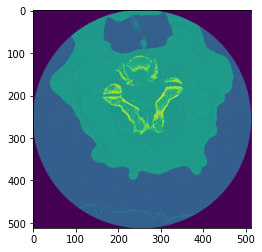

In [11]:
plt.imshow(imgs_tensor[100, :, :])

## get boundary

In [12]:
def get_axial_boundary_from_segmentation(seg, pixel_spacing, throw=100, tol=0.2, max_mm=100):
    """
    seg : H x W
    """
    image_size = seg.shape[0]
    min_size = min(image_size, max_mm / pixel_spacing)
    
    rows, columns = seg.nonzero()
    rows.sort()
    columns.sort()
    
    throw = min(len(rows) // 2, throw)
    
    if(len(rows)) == 0:
        return 0, 0, image_size, image_size
    
    xmin, xmax = columns[throw], columns[-throw]
    ymin, ymax = rows[throw], rows[-throw]
    
    w = (xmax - xmin) * (1 + tol)
    h = (ymax - ymax) * (1 + tol)
    new_size = max(w, h, min_size)
    new_size = min(image_size, new_size)
    
    xcenter, ycenter = (xmax + xmin) / 2, (ymax + ymin) / 2
    
    xmin = min(image_size - new_size, xcenter - new_size / 2)
    xmin = max(0, xmin)
    
    ymin = min(image_size - new_size, ycenter - new_size / 2)
    ymin = max(0, ymin)
    
    return xmin, ymin, xmin + new_size, ymin + new_size

In [13]:
@torch.no_grad()
def predict_seg(x, model):
    """
    return: N x 1 x H x W
    """
    x = x.to(device)
    logits = model(x)

    classification_score, mse_score = logits.sigmoid().chunk(2, dim=1)
    classification_pred = classification_score.gt(0.5).float()
    pred = (classification_pred * mse_score).cpu()
    
    return pred

torch.Size([247, 1, 256, 256])


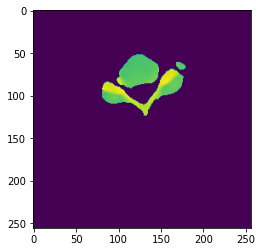

In [14]:
@torch.no_grad()
def seg_patient(imgs_tensor, model, batch_size=16):
    
    seg_result = []
    for i in range(math.ceil(imgs_tensor.shape[0] / batch_size)):
        batch_tensor = imgs_tensor[i * batch_size : i * batch_size + batch_size]
        batch_tensor = torch.stack((batch_tensor, batch_tensor, batch_tensor), axis=1)
        batch_tensor = TF.resize(batch_tensor, (256, 256))
        # print(batch_tensor.shape)
        
        seg = predict_seg(batch_tensor, model)
        seg_result.append(seg)
        
    return torch.cat(seg_result, axis=0)

seg_result = seg_patient(imgs_tensor, seg_model)
print(seg_result.shape)
plt.imshow(seg_result[seg_result.shape[0] // 2, 0, :, :])

(247, 4)
[ 73.82708373   0.         442.17291627 368.34583254]


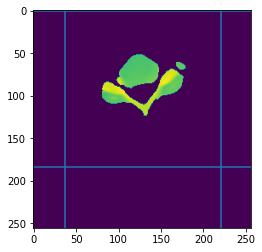

In [15]:
def get_axial_boundary(segs, img_size=256):
    boundary_list = []
    for i in range(segs.shape[0]):
        seg = segs[i, 0, :, :].numpy()
        # print(seg.shape)
        boundary = get_axial_boundary_from_segmentation(seg, pixel_spacing, throw=50, tol=0.2, max_mm=50)
        boundary_list.append(boundary)
    boundary_list = np.asarray(boundary_list) * (512 / img_size)
    return boundary_list

axial_boundary = get_axial_boundary(seg_result)
print(axial_boundary.shape)

print(axial_boundary[axial_boundary.shape[0] // 2, :])

boundary = axial_boundary[axial_boundary.shape[0] // 2, :] / 2
plt.imshow(seg_result[seg_result.shape[0] // 2, 0, :, :])
plt.axvline(boundary[0])
plt.axvline(boundary[2])
plt.axhline(boundary[1])
plt.axhline(boundary[3])

### Detection

torch.Size([245, 4])


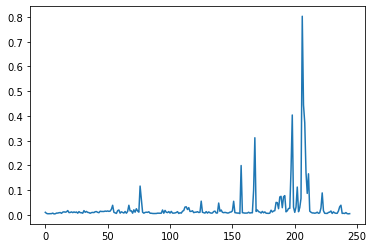

In [16]:
@torch.no_grad()
def predict_det(x, model):
    x = x.to(device)
    bboxes = model(x) # N x 1 x 6
    
    return bboxes.cpu()[:, 0, :]
    
    
def crop_resize_images(imgs_tensor, boundary_list, img_size=512):
    croped_list = []
    for i in range(imgs_tensor.shape[0]):
        xmin, ymin, xmax, ymax = boundary_list[i, :]
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        # print(xmin, ymin, xmax, ymax)
        croped = TF.crop(imgs_tensor[i, :, :, :], top=ymin, left=xmin, height=ymax-ymin, width=xmax-xmin)
        croped = TF.resize(croped, (img_size, img_size))
        croped_list.append(croped)
        
    return torch.stack(croped_list, 0)

def get_original_bbox(bbox, boundary):
    scale = 512. / (boundary[:, [2]] - boundary[:, [0]])
    
    org_bbox = bbox / scale
    org_bbox[:, 0] += boundary[:, 0]
    org_bbox[:, 1] += boundary[:, 1]
    org_bbox[:, 2] += boundary[:, 0]
    org_bbox[:, 3] += boundary[:, 1]
    
    return org_bbox

@torch.no_grad()
def det_patient(imgs_tensor, model, boundary, batch_size=16):
    det_result = []
    
    imgs_tensor = torch.stack((imgs_tensor[0:-2, :, :], imgs_tensor[1:-1, :, :], imgs_tensor[2:, :, :]), axis=1)
    # print(imgs_tensor.shape)
    
    boundary = boundary[1:-1, :]
    # print(boundary.shape)
    
    imgs_tensor = crop_resize_images(imgs_tensor, boundary)
    
    # print(imgs_tensor.shape)
    for i in range(math.ceil(imgs_tensor.shape[0] / batch_size)):
        batch_tensor = imgs_tensor[i * batch_size : i * batch_size + batch_size]
        
        
        pred = predict_det(batch_tensor, model)
        det_result.append(pred)
    
    # det_result.append(torch.tensor([0,0,0,0,0,0]))
    det_result = torch.cat(det_result, axis=0)
    # print(det_result.shape)
    
    bboxes, scores = get_original_bbox(det_result[:, :4], boundary), det_result[:, 4]
    
    return bboxes, scores

bboxes, scores = det_patient(imgs_tensor, det_model, axial_boundary)
print(bboxes.shape)
plt.plot(scores)

tensor(206)
torch.Size([245])
torch.Size([247, 512, 512])


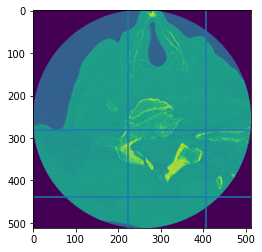

In [17]:
max_score_index = scores.argmax()
print(max_score_index)
print(scores.shape)
print(imgs_tensor.shape)
plt.imshow(imgs_tensor[max_score_index+1, :, :])
plt.axvline(bboxes[max_score_index+1, 0])
plt.axvline(bboxes[max_score_index+1, 2])
plt.axhline(bboxes[max_score_index+1, 1])
plt.axhline(bboxes[max_score_index+1, 3])

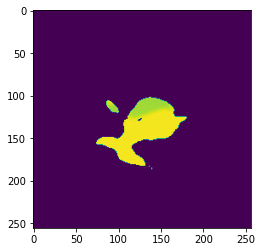

In [18]:
plt.imshow(seg_result[max_score_index + 1, 0, :, :])

### get bbox class

In [19]:
def get_bbox_class(seg, bbox):
    """
    label 은 0.125 의 단위로, 
    seg: H x W
    bbox: [xmin, ymin, xmax, ymax]
    """
    xmin, ymin, xmax, ymax = bbox.int()
    area = seg[ymin:ymax, xmin:xmax]
    
    # print(area)
    result = torch.mean(area[area>0])
    result = torch.round(result / 0.125)
    
    return result

# seg_list = seg_result[1:-1, 0, :, :]
# seg_bboxes = bboxes / 2
# check_index=362
# get_bbox_class(seg_list[check_index, :, :], seg_bboxes[check_index, :])


torch.Size([245])
max 7.0


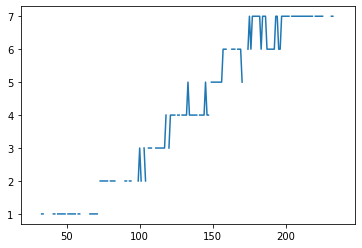

In [20]:
def get_bbox_class_list(seg_list, seg_bboxes):
    class_list = []
    for i in range(seg_list.shape[0]):
        class_index = get_bbox_class(seg_list[i, :, :], seg_bboxes[i, :])
        class_list.append(class_index)
        
    return torch.stack(class_list)

class_list = get_bbox_class_list(seg_result[1:-1, 0, :, :], bboxes / 2)
print(class_list.shape)
print(f"max {class_list[max_score_index]}")
plt.plot(class_list)

In [21]:
def cal_loss(prob, label):
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum() / weight_total.sum()

In [25]:
def get_prob(scores, class_list, eps=1e-2):
    prob = np.zeros(8) + eps
    # prob[0] = scores.max()
    
    for i in range(len(scores)):
        score = scores[i]
        
        
        if torch.isnan(class_list[i]):
            continue
        
        class_index = int(class_list[i])
        prob[class_index] = min(1-eps, max(prob[class_index], score))
    
    prob[0] = prob.max()
    
    return prob

prob = get_prob(scores, class_list)
print(prob)

[0.80309451 0.03899008 0.11662269 0.03273617 0.04795898 0.05517111
 0.31194741 0.80309451]


In [23]:
imgs, aspect, pixel_spacing = read_patient_dcm(os.path.join(IMAGES_DIR, UID))
# print(imgs.shape)
# print(aspect)
# print(pixel_spacing)

cliped_imgs = np.clip(imgs, a_min=-2242, a_max=2242) / 4484 + 0.5
imgs_tensor = torch.tensor(cliped_imgs, dtype=torch.float)
imgs_tensor = (imgs_tensor - 0.5) * 2.
# print(imgs_tensor.shape)
# print(imgs_tensor.min(), imgs_tensor.max())

seg_result = seg_patient(imgs_tensor, seg_model)
axial_boundary = get_axial_boundary(seg_result)
bboxes, scores = det_patient(imgs_tensor, det_model, axial_boundary)


max_score_index = scores.argmax()
print(max_score_index)
print(scores.shape)
print(imgs_tensor.shape)
plt.imshow(imgs_tensor[max_score_index+1, :, :])
plt.axvline(bboxes[max_score_index+1, 0])
plt.axvline(bboxes[max_score_index+1, 2])
plt.axhline(bboxes[max_score_index+1, 1])
plt.axhline(bboxes[max_score_index+1, 3])


class_list = get_bbox_class_list(seg_result[1:-1, 0, :, :], bboxes / 2)
prob = get_prob(scores, class_list)

# print(prob)

loss = cal_loss(prob, label)
loss

0.976935509043357

In [35]:
def infer_patient(UID, label):
    imgs, aspect, pixel_spacing = read_patient_dcm(os.path.join(IMAGES_DIR, UID))
    # print(imgs.shape)
    # print(aspect)
    # print(pixel_spacing)

    cliped_imgs = np.clip(imgs, a_min=-2242, a_max=2242) / 4484 + 0.5
    imgs_tensor = torch.tensor(cliped_imgs, dtype=torch.float)
    imgs_tensor = (imgs_tensor - 0.5) * 2.
    # print(imgs_tensor.shape)
    # print(imgs_tensor.min(), imgs_tensor.max())

    seg_result = seg_patient(imgs_tensor, seg_model)
    axial_boundary = get_axial_boundary(seg_result)
    bboxes, scores = det_patient(imgs_tensor, det_model, axial_boundary)


    max_score_index = scores.argmax()
    # print(max_score_index)
    # print(scores.shape)
    # print(imgs_tensor.shape)
    # plt.imshow(imgs_tensor[max_score_index+1, :, :])
    # plt.axvline(bboxes[max_score_index+1, 0])
    # plt.axvline(bboxes[max_score_index+1, 2])
    # plt.axhline(bboxes[max_score_index+1, 1])
    # plt.axhline(bboxes[max_score_index+1, 3])


    class_list = get_bbox_class_list(seg_result[1:-1, 0, :, :], bboxes / 2)
    prob = get_prob(scores, class_list)

    # print(prob)

    loss = cal_loss(prob, label)

    # print("loss is", loss)
    return loss


losses = []
for index in tqdm(range(458, 468)):

    UID = train_df.iloc[index]['StudyInstanceUID']
    # print(UID)
    label = train_df.iloc[index][['patient_overall', 'C1','C2','C3','C4','C5','C6','C7']].values
    # print(label)
    
    loss = infer_patient(UID, label)
    print(f'{index} {UID} loss {loss}')
    losses.append(loss)
    
print(np.mean(losses))
    

 10%|█         | 1/10 [00:04<00:43,  4.87s/it]

458 1.2.826.0.1.3680043.1708 loss 0.12700661042287748


 20%|██        | 2/10 [00:14<01:03,  7.89s/it]

459 1.2.826.0.1.3680043.17094 loss 0.22823591612154182


 30%|███       | 3/10 [00:27<01:10, 10.13s/it]

460 1.2.826.0.1.3680043.171 loss 0.5762442149211248


 40%|████      | 4/10 [00:36<00:57,  9.64s/it]

461 1.2.826.0.1.3680043.17127 loss 0.7257139592996935


 50%|█████     | 5/10 [00:47<00:50, 10.00s/it]

462 1.2.826.0.1.3680043.17129 loss 0.01728194971197011


 60%|██████    | 6/10 [00:55<00:37,  9.33s/it]

463 1.2.826.0.1.3680043.17166 loss 0.10772853367407231


 70%|███████   | 7/10 [01:03<00:26,  9.00s/it]

464 1.2.826.0.1.3680043.17170 loss 0.1011907532729713


 80%|████████  | 8/10 [01:12<00:17,  8.90s/it]

465 1.2.826.0.1.3680043.17184 loss 0.15903963349767894


 90%|█████████ | 9/10 [01:23<00:09,  9.50s/it]

466 1.2.826.0.1.3680043.17194 loss 0.027778231862422762


100%|██████████| 10/10 [01:34<00:00,  9.42s/it]

467 1.2.826.0.1.3680043.17208 loss 0.629332702071072
0.2699552504855425
